In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import calendar
from lightgbm import LGBMClassifier
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
pio.renderers.default = 'notebook_connected'

In [2]:
df = pd.read_csv("PM01.csv")

In [3]:
# df.to_csv("PM01.csv",index=False)

In [4]:
df['Time stamp start'] = pd.to_datetime(df['Time stamp start'])
df['Time stamp end'] = pd.to_datetime(df['Time stamp end'])

In [5]:
df['Months_start'] = df['Time stamp start'].dt.month
df['WeekDays_start'] = df['Time stamp start'].dt.weekday

df['Months_end'] = df['Time stamp end'].dt.month
df['WeekDays_end'] = df['Time stamp end'].dt.weekday

In [6]:
df['Work Center'].value_counts()

W9120    24264
W9110    23205
W9130     3133
Name: Work Center, dtype: int64

In [7]:
median = df['Year of Mfg'].median()
df['Year of Mfg'] = df['Year of Mfg'].fillna(median)

In [8]:
unique_values = df.groupby("Equipment")["Manufacturer"].unique()

In [9]:
unique_values

Equipment
M5930-10050                 [Moehwald]
M5930-11086            [Weisstechniil]
M5930-11517                   [Studer]
M5930-3039          [Fortuna Werke AG]
M5930-3283                  [MICO/RMB]
                        ...           
M5930-7832                       [HMT]
M5930-9018                  [MICO/RMB]
M5930-9577         [Ultraseal (I) ltd]
M5930-9874     [Nagal spl m/c pvt ltd]
M5930-S009                     [STHLI]
Name: Manufacturer, Length: 318, dtype: object

In [10]:
le = LabelEncoder()
df['Breakdown_encoded'] = le.fit_transform(df['Breakdown'])

## Visualization

In [11]:
brand_breakdown = pd.crosstab(df['Manufacturer'], df['Breakdown'])

brand_breakdown.T


Manufacturer,14256 Erwin Junker,AT-MO,ATMO,ATMO Bangalore,AUTHENTIC ENGINEERS,Abhay Products,"Auram Machines, Pune",BFW,BHARAT FRITZ WERNER LTD,BOSCH,...,VEB,VINZE MAGNAFIELD CONTROLSPVT L,Weisstechniil,Wolpert wilson instruments,XLO,Zeiss,Ziersch & Baltrusch,jaswant,karisma Instruments,nufacturer FeP
Breakdown,,,,,,,,,,,,,,,,,,,,,
No,16,294,1721,3,15,18,3,11,7,349,...,34,62,21,3,5,1,7,1,1,182
Yes,3,68,211,0,4,7,0,1,1,111,...,16,19,5,4,2,2,0,1,0,14


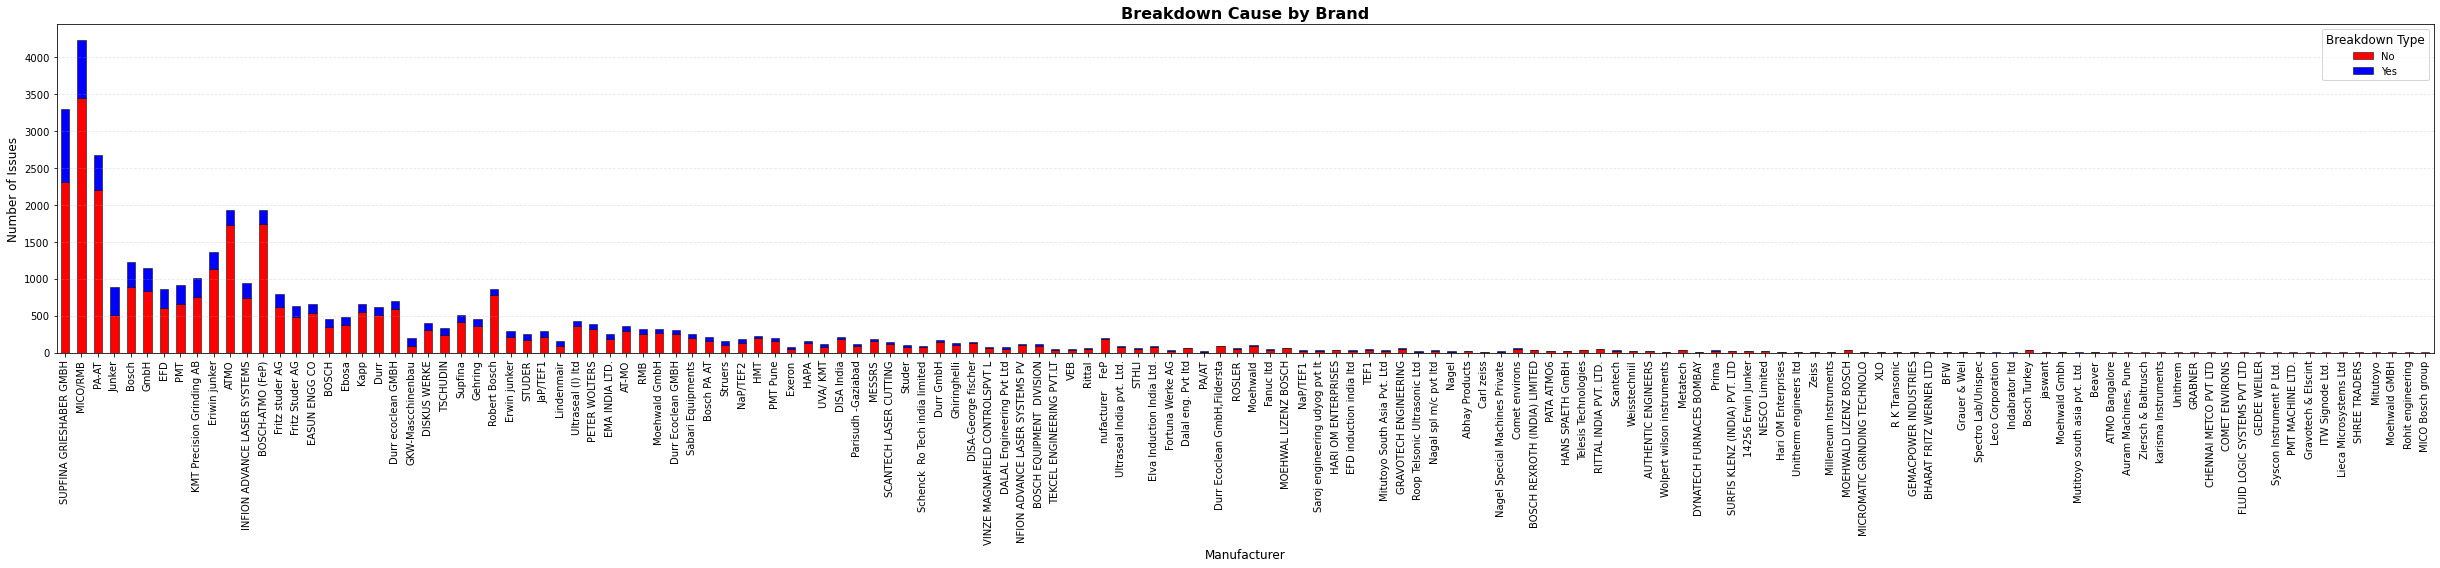

In [12]:
brand_breakdown_sorted = brand_breakdown.sort_values(by="Yes", ascending=False)

brand_breakdown_sorted.plot(
    kind='bar',
    stacked=True,
    color=['red', 'blue'],  
    figsize=(34, 8),
    edgecolor='black',
    linewidth=0.5
)

plt.title("Breakdown Cause by Brand", fontsize=16, fontweight='bold')
plt.xlabel("Manufacturer", fontsize=12)
plt.ylabel("Number of Issues", fontsize=12)
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Breakdown Type", title_fontsize=12, fontsize=10, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
monthly_brand = (
    df.groupby(['Manufacturer', 'Months_start'])['Breakdown_encoded'].sum()
      .unstack()
      .fillna(0)
)

monthly_brand.columns = [calendar.month_name[int(col)] if str(col).isdigit() else str(col) for col in monthly_brand.columns]

month_order = list(calendar.month_name)[1:] 
monthly_brand = monthly_brand[[m for m in month_order if m in monthly_brand.columns]]

monthly_brand = monthly_brand.loc[
    monthly_brand.sum(axis=1).sort_values(ascending=False).index
]

fig = go.Figure()

for month_name in monthly_brand.columns:
    fig.add_trace(go.Bar(
        x=monthly_brand.index,
        y=monthly_brand[month_name],
        name=month_name,
        hovertemplate=(
            f'Manufacturer: %{{x}}<br>'
            f'Month: {month_name}<br>'
            'Breakdowns: %{y}<extra></extra>'
        ),
    ))

fig.update_layout(
    barmode='stack',
    title={
        'text': "Monthly Breakdown by Brand",
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=22, family='Arial', color='black')
    },
    xaxis_title="Manufacturer",
    yaxis_title="Breakdown Count",
    xaxis=dict(tickangle=90, tickfont=dict(size=10)),
    yaxis=dict(tickfont=dict(size=10)),
    legend=dict(
        title='Month',
        font=dict(size=10),
        orientation='h',
        y=1.1
    ),
    height=600,
    width=1400,
    margin=dict(l=40, r=40, t=80, b=150),
)

fig.show()

In [14]:
monthly_cost = df.groupby('Months_start')["Total costs"].sum()

month_order = list(calendar.month_name)[1:]  # ['January', ..., 'December']
monthly_cost = monthly_cost.reindex([m for m in month_order if m in monthly_cost.index])

fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthly_cost.index,
    y=monthly_cost.values,
    marker_color='skyblue',
    marker_line_color='black',
    marker_line_width=1,
    hovertemplate='Month: %{x}<br>Total Cost: ₹%{y:,.2f}<extra></extra>',
))

# Step 5: Layout formatting
fig.update_layout(
    title={
        'text': "Total Cost per Month from 2022 - 2025",
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=18, family='Arial', color='black')
    },
    xaxis_title="Month",
    yaxis_title="Cost",
    xaxis=dict(tickfont=dict(size=12)),
    yaxis=dict(tickfont=dict(size=12)),
    height=500,
    width=900,
    margin=dict(l=40, r=40, t=80, b=60),
    plot_bgcolor='white',
)

fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

fig.show()

In [15]:
brand_cost = df.groupby('Manufacturer')['Total costs'].sum()

brand_cost_sorted = brand_cost.sort_values(ascending=False)

top_brand = brand_cost_sorted.idxmax()
top_cost = brand_cost_sorted.max()

print(f"The brand causing the maximum total cost is: {top_brand}")
print(f"Total cost incurred: ₹{top_cost:,.2f}")


The brand causing the maximum total cost is: MICO/RMB
Total cost incurred: ₹4,600,367.39


In [16]:
# # brand_cost_millions = brand_cost_sorted / 1_000_000

# fig = go.Figure()

# fig.add_trace(go.Bar(
#     x=brand_cost.index,
#     y=brand_cost.values,
#     marker_color='salmon',
#     marker_line_color='black',
#     marker_line_width=1,
#     text=[f'{v:.2f}M' for v in brand_cost.values], 
#     textposition='outside',
#     hovertemplate='Manufacturer: %{x}<br>Total Cost: ₹%{y:.2f}M<extra></extra>',
# ))

# fig.update_layout(
#     title={
#         'text': "Total Cost by Brand",
#         'x': 0.5,
#         'xanchor': 'center',
#         'font': dict(size=20, family='Arial', color='black')
#     },
#     xaxis_title="Manufacturer",
#     yaxis_title="Total Cost (in Millions ₹)",
#     xaxis=dict(tickangle=90, tickfont=dict(size=10)),
#     yaxis=dict(tickfont=dict(size=12)),
#     height=600,
#     width=1400,
#     margin=dict(l=40, r=40, t=80, b=150),
#     plot_bgcolor='white',
# )

# fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

# fig.show()



fig = go.Figure()

fig.add_trace(go.Bar(
    x=brand_cost_sorted.index,
    y=brand_cost_sorted.values,
    marker_color='salmon',
    marker_line_color='black',
    marker_line_width=1,
    text=[f'{v:,.0f}' for v in brand_cost_sorted.values],  
    textposition='outside',  
    hovertemplate='Manufacturer: %{x}<br>Total Cost: ₹%{y:,.0f}<extra></extra>',
))

fig.update_layout(
    title={
        'text': "Total Cost by Brand",
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=20, family='Arial', color='black')
    },
    xaxis_title="Manufacturer",
    yaxis_title="Total Cost",
    xaxis=dict(tickangle=90, tickfont=dict(size=10)),
    yaxis=dict(tickfont=dict(size=12)),
    height=600,
    width=1400,
    margin=dict(l=40, r=40, t=80, b=150),
    plot_bgcolor='white',
)

# Optional gridlines
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

fig.show()

In [17]:
len(df['Manufacturer'].unique())

145

In [18]:
NO_pr = df[df['Breakdown']=="No"]['Breakdown']
percentage_no = len(NO_pr)/len(df['Breakdown'])*100

Yes_pr = df[df['Breakdown']=="Yes"]['Breakdown']
percentage_yes = len(Yes_pr)/len(df['Breakdown'])*100

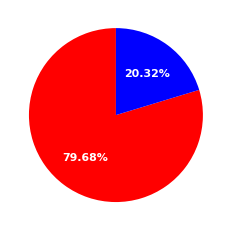

In [19]:
plt.pie([percentage_no,percentage_yes],labels = ['No',"YES"],colors = ['red','blue'],autopct='%1.2f%%',startangle=90,
       textprops={'color': 'white', 'fontsize': 11, 'fontweight': 'bold'})
plt.show()

In [20]:
if pd.api.types.is_numeric_dtype(df['Months_start']):
    df['Months_start'] = df['Months_start'].apply(lambda x: calendar.month_name[int(x)] if pd.notnull(x) else x)

brand_month_summary = df.groupby(['Manufacturer', 'Months_start']).size().reset_index(name='Count')

month_order = list(calendar.month_name)[1:] 

fig = px.bar(
    brand_month_summary,
    x='Months_start',
    y='Count',
    color='Manufacturer',
    title='Breakdowns by Brand and Month',
    labels={'Months_start': 'Month', 'Count': 'Breakdowns'},
    category_orders={'Months_start': month_order}
)

fig.update_layout(
    xaxis_tickangle=0,
    height=600,
    width=1200,
    barmode='group'
)

fig.show()

In [21]:
summary = df.groupby(['Manufacturer', 'Months_start', 'Breakdown']).size().reset_index(name='Count')

fig = px.bar(
    summary,
    x='Months_start',
    y='Count',
    color='Manufacturer',
    facet_col='Breakdown',
    title='Breakdown Comparison by Brand and Month',
    labels={'Months_start': 'Month', 'Count': 'Breakdowns'},
    category_orders={'Months_start': month_order}
)
fig.show()

In [22]:
if pd.api.types.is_numeric_dtype(df['Months_start']):
    df['Months_start'] = df['Months_start'].apply(lambda x: calendar.month_name[int(x)] if pd.notnull(x) else x)
month_order = list(calendar.month_name)[1:]

# Group by Manufacturer and Month, summing the cost
cost_summary = df.groupby(['Manufacturer', 'Months_start'])['Total costs'].sum().reset_index()

fig = px.density_heatmap(
    cost_summary,
    x='Months_start',
    y='Manufacturer',
    z='Total costs',
    color_continuous_scale='Viridis',
    title='Total Cost by Brand and Month',
    labels={'Months_start': 'Month', 'Manufacturer': 'Brand', 'Cost': 'Total Cost'},
    category_orders={'Months_start': month_order}
)

fig.update_layout(
    width=1500,
    height=1000
)

fig.show()

In [23]:
df['Year'] = pd.to_datetime(df['Time stamp start']).dt.year

yearly_breakdowns = df.groupby('Year').size().reset_index(name='Breakdown_Count')

max_year_row = yearly_breakdowns.loc[yearly_breakdowns['Breakdown_Count'].idxmax()]

print("Year with the most breakdowns:")
print(f"Year: {max_year_row['Year']}")
print(f"Total Breakdowns: {max_year_row['Breakdown_Count']}")


Year with the most breakdowns:
Year: 2022
Total Breakdowns: 17892


In [24]:
fig = px.bar(
    yearly_breakdowns,
    x='Year',
    y='Breakdown_Count',
    title='Total Breakdowns per Year',
    labels={'Breakdown_Count': 'Number of Breakdowns'},
    color='Breakdown_Count',
    color_continuous_scale='Blues'
)

fig.update_layout(
    height=500,
    width=800
)

fig.show()

In [25]:
df['Time stamp start'] = pd.to_datetime(df['Time stamp start'], errors='coerce')

df['Weekday'] = df['Time stamp start'].dt.day_name()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_breakdown = df.groupby('Weekday')['Breakdown_encoded'].sum().reindex(weekday_order)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=weekday_breakdown.index,
    y=weekday_breakdown.values,
    marker_color='teal',
    marker_line_color='black',
    marker_line_width=1,
    text=weekday_breakdown.values,
    textposition='outside',
    hovertemplate='Weekday: %{x}<br>Breakdowns: %{y}<extra></extra>',
))

fig.update_layout(
    title={
        'text': "Breakdowns by Weekday",
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=18, family='Arial', color='black')
    },
    xaxis_title="Weekday",
    yaxis_title="Breakdown Count",
    xaxis=dict(tickfont=dict(size=12)),
    yaxis=dict(tickfont=dict(size=12)),
    height=500,
    width=900,
    margin=dict(l=40, r=40, t=80, b=60),
    plot_bgcolor='white',
)

fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')

fig.show()


In [26]:
# fig = px.bar(df,x="Equipment",y="Work Center",color = "Manufacturer")
# fig.show()

In [27]:
X = df[["Breakdown", "Manufacturer", "Year of Mfg"]].copy()
X[["Manufacturer","Breakdown"]] = X[["Manufacturer","Breakdown"]].astype("category")

y_equipment = df['Equipment'].astype("category")
y_work = df['Work Center'].astype("category")
y_month = df['Months_start'].astype("category")

In [28]:
X_train_e,X_test_e,y_train_e,y_test_e = train_test_split(X,y_equipment,test_size=0.2,random_state=43)

In [29]:
X_train_w,X_test_w,y_train_w,y_test_w = train_test_split(X,y_work,test_size=0.2,random_state=43)

In [30]:
X_train_m,X_test_m,y_train_m,y_test_m = train_test_split(X,y_month,test_size=0.2,random_state=43)

In [31]:
equipment_model = LGBMClassifier(class_weight='balanced',verbose=-1)
equipment_model.fit(X_train_e, y_train_e)

workcenter_model = LGBMClassifier(class_weight='balanced',verbose=-1)
workcenter_model.fit(X_train_w, y_train_w)

month_model = LGBMClassifier(class_weight='balanced',verbose=-1)
month_model.fit(X_train_m, y_train_m)

LGBMClassifier(class_weight='balanced', verbose=-1)

In [32]:
y_pred_e = equipment_model.predict(X_test_e)
y_pred_w = workcenter_model.predict(X_test_w)
y_pred_m = month_model.predict(X_test_m)

print("Equipment Prediction Accuracy: {:.2f}%".format(accuracy_score(y_test_e, y_pred_e)*100))
print("Work Center Prediction Accuracy: {:.2f}%:".format(accuracy_score(y_test_w, y_pred_w)*100))
print("Month Prediction Accuracy: {:.2f}%".format(accuracy_score(y_test_m, y_pred_m)*100))

Equipment Prediction Accuracy: 4.43%
Work Center Prediction Accuracy: 48.18%:
Month Prediction Accuracy: 10.98%


In [33]:
df['Equipment_Age'] = 2025 - df['Year of Mfg']

In [34]:
df.columns

Index(['Order', 'Equipment', 'Equipm. description', 'Order text',
       'Work Center', 'Planner group', 'Malfunction start',
       'Start of Malfunctn (Time)', 'Malfunction end', 'Malfunctn End (Time)',
       'Breakdown duration', 'Breakdown', 'Cause text', 'Functional Location',
       'Material (intern + extern)', 'Total costs', 'Wage/internal service',
       'Time stamp start', 'Time stamp end', 'Hrs', 'Min', 'Sec', 'Total Hrs',
       'Status', 'Manufacturer', 'Year of Mfg', 'Local / Imported',
       'New/ Re-Use', 'Months_start', 'WeekDays_start', 'Months_end',
       'WeekDays_end', 'Breakdown_encoded', 'Year', 'Weekday',
       'Equipment_Age'],
      dtype='object')

In [35]:
df['Weekday']

0        Saturday
1        Saturday
2        Saturday
3        Saturday
4        Saturday
           ...   
50597      Friday
50598      Friday
50599      Friday
50600      Friday
50601      Friday
Name: Weekday, Length: 50602, dtype: object

In [36]:
fd = df[["Equipment","Work Center","Breakdown","Breakdown_encoded","Months_start","Weekday","Total costs","Manufacturer","Year of Mfg","Equipment_Age"]]

In [37]:
fd.to_csv("Pm1.csv",index=False)